<a href="https://colab.research.google.com/github/ProferKvak/watermarking-an-image/blob/main/Copy_of_Untitled1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from multiprocessing import Pool

import os
import numpy as np
import mne
import pandas as pd
import random

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq, rfft, rfftfreq
from sklearn.preprocessing import quantile_transform
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.preprocessing import robust_scale
import mne
import matplotlib 
from collections import defaultdict
from math import cos, sin, acos, radians, pi
from scipy.interpolate import griddata
from numpy import newaxis
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils


import pywt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_dir = '/content/drive/MyDrive/Major project /archive.zip (Unzipped Files)/SMNI_CMI_TRAIN/Train'
test_dir = '/content/drive/MyDrive/Major project /archive.zip (Unzipped Files)/SMNI_CMI_TEST/Test'

def read_csv(filename):
    'converts a filename to a pandas dataframe'
    return pd.read_csv(filename)

files_train = os.listdir(train_dir)
file_list_train = [os.path.join(train_dir,filename) for filename in files_train if filename.split('.')[1]=='csv']
                     
files_test = os.listdir(test_dir)
file_list_test = [os.path.join(test_dir,filename) for filename in files_test if filename.split('.')[1]=='csv']
                     
with Pool(processes=12) as pool:

    df_list_train = pool.map(read_csv, file_list_train)
    df_list_test =  pool.map(read_csv, file_list_test)

combined_df_train = pd.concat(df_list_train, ignore_index=True)
combined_df_test = pd.concat(df_list_test, ignore_index=True)
combined_df = pd.concat([combined_df_train,combined_df_test], ignore_index=True)

EEG_data = combined_df[combined_df['subject identifier'] == 'a']
EEG_data_control = combined_df[combined_df['subject identifier'] == 'c']

del combined_df

In [ ]:
EEG_data.head()

,Unnamed: 0,trial number,sensor position,sample num,sensor value,subject identifier,matching condition,channel,name,time
0,5,19,FP1,0,-0.112,a,"S2 nomatch,",0,co2a0000364,0.000000
1,6,19,FP1,1,-1.577,a,"S2 nomatch,",0,co2a0000364,0.003906
2,7,19,FP1,2,-4.018,a,"S2 nomatch,",0,co2a0000364,0.007812
3,8,19,FP1,3,-6.460,a,"S2 nomatch,",0,co2a0000364,0.011719
4,9,19,FP1,4,-7.436,a,"S2 nomatch,",0,co2a0000364,0.015625


In [ ]:
EEG_data.shape

(7782400, 10)

In [ ]:
EEG_data_control.head()

,Unnamed: 0,trial number,sensor position,sample num,sensor value,subject identifier,matching condition,channel,name,time
2457600,5,16,FP1,0,-6.755,c,S1 obj,0,co2c0000337,0.000000
2457601,6,16,FP1,1,-6.266,c,S1 obj,0,co2c0000337,0.003906
2457602,7,16,FP1,2,-6.755,c,S1 obj,0,co2c0000337,0.007812
2457603,8,16,FP1,3,-6.755,c,S1 obj,0,co2c0000337,0.011719
2457604,9,16,FP1,4,-4.801,c,S1 obj,0,co2c0000337,0.015625


In [ ]:
EEG_data_control.shape

(7749632, 10)

In [ ]:
EEG_data = EEG_data.drop(['Unnamed: 0'], axis=1)
EEG_data.loc[EEG_data['matching condition'] == 'S2 nomatch,', 'matching condition'] =  'S2 nomatch' 

EEG_data.loc[EEG_data['sensor position'] == 'AF1', 'sensor position'] = 'AF3'
EEG_data.loc[EEG_data['sensor position'] == 'AF2', 'sensor position'] = 'AF4'
EEG_data.loc[EEG_data['sensor position'] == 'PO1', 'sensor position'] = 'PO3'
EEG_data.loc[EEG_data['sensor position'] == 'PO2', 'sensor position'] = 'PO4'

EEG_data.loc[EEG_data['sensor position'] == 'FP1', 'sensor position'] = 'Fp1'
EEG_data.loc[EEG_data['sensor position'] == 'FP2', 'sensor position'] = 'Fp2'
EEG_data.loc[EEG_data['sensor position'] == 'CPZ', 'sensor position'] = 'CPz'
EEG_data.loc[EEG_data['sensor position'] == 'FZ', 'sensor position'] = 'Fz'

EEG_data.loc[EEG_data['sensor position'] == 'CZ', 'sensor position'] = 'Cz' 
EEG_data.loc[EEG_data['sensor position'] == 'PZ', 'sensor position'] = 'Pz'
EEG_data.loc[EEG_data['sensor position'] == 'FPZ', 'sensor position'] = 'Fpz'
EEG_data.loc[EEG_data['sensor position'] == 'AFZ', 'sensor position'] = 'AFz'
EEG_data.loc[EEG_data['sensor position'] == 'FCZ', 'sensor position'] = 'FCz'

EEG_data.loc[EEG_data['sensor position'] == 'POZ', 'sensor position'] = 'POz'
EEG_data.loc[EEG_data['sensor position'] == 'OZ', 'sensor position'] = 'Oz'


In [ ]:
Alc_S1Obj = EEG_data[EEG_data['matching condition'] == 'S1 obj']
Alc_S2Match = EEG_data[EEG_data['matching condition'] == 'S2 match']
Alc_S2Nomatch = EEG_data[EEG_data['matching condition'] == 'S2 nomatch']
Con_S1Obj = EEG_data_control[EEG_data_control['matching condition'] == 'S1 obj']
Con_S2Match = EEG_data_control[EEG_data_control['matching condition'] == 'S2 match']
Con_S2Nomatch = EEG_data_control[EEG_data_control['matching condition'] == 'S2 nomatch']


def trial_len_integrity_check(inputDF):

  nameAndTrialNumber = inputDF.groupby(['trial number','name']).size().reset_index().rename(columns={0:'count'})
  nameAndTrialNumber['count'] =np.where(nameAndTrialNumber['count'] == 16384,False,True)

  del inputDF

  if nameAndTrialNumber['count'].any():
    Exception('Data Integrity problem, one of the arrays is not shaped 256x256')

  return nameAndTrialNumber[['trial number','name']]

Con_S1Obj_Index = trial_len_integrity_check(Con_S1Obj) 
Con_S2Match_Index = trial_len_integrity_check(Con_S2Match) 
Con_S2Nomatch_Index = trial_len_integrity_check(Con_S2Nomatch) 

Alc_S1Obj_Index = trial_len_integrity_check(Alc_S1Obj) 
Alc_S2Match_Index = trial_len_integrity_check(Alc_S2Match) 
Alc_S2Nomatch_Index = trial_len_integrity_check(Alc_S2Nomatch) 

All_Alcs = pd.concat([Alc_S1Obj_Index,Alc_S2Match_Index,Alc_S2Nomatch_Index])
All_Cons = pd.concat([Con_S1Obj_Index,Con_S2Match_Index,Con_S2Nomatch_Index])

All_Alcs.reset_index(drop=True,inplace=True)
All_Cons.reset_index(drop=True,inplace=True)

In [ ]:

TrueCrimeSubjectZero = EEG_data[((EEG_data.name == 'co2a0000364') & (EEG_data['trial number'] == 0))]
print('Number of data points on example subject Zero, Trial Zero')
print(TrueCrimeSubjectZero.shape)
print('Number of Channels')
print(TrueCrimeSubjectZero.shape[0] / 256)
print('Sampling Rate')
print(TrueCrimeSubjectZero.shape[0] / 64)

Number of data points on example subject Zero, Trial Zero
(16384, 9)
Number of Channels
64.0
Sampling Rate
256.0


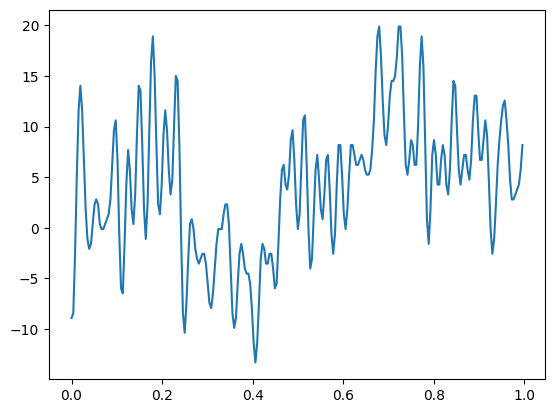

In [ ]:
oneSensor = TrueCrimeSubjectZero[TrueCrimeSubjectZero['sensor position'] == 'Fp1']

time = oneSensor['time']
sensorValue = oneSensor['sensor value']

plt.plot(time,sensorValue)
plt.show()

256


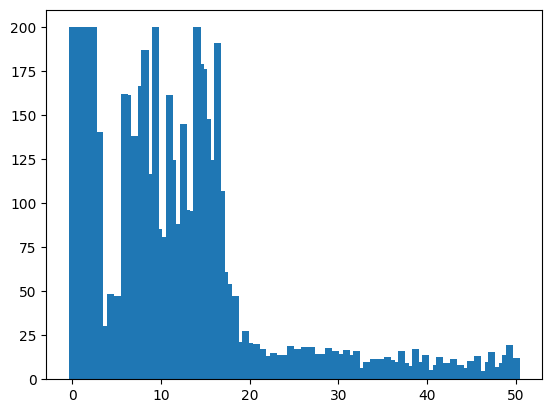

In [ ]:
from scipy.fft import fft, fftfreq

N = 256 * 1 

yf = abs(fft(sensorValue.astype(np.int64)))
PowerFilterIndex =  np.where(yf >= 200)[0]

yf[PowerFilterIndex] = 200

variance = np.std(yf)**2
N = len(yf)

xf = abs(fftfreq(N, 1 / 100))

print(len(yf))

plt.bar(xf, yf)
plt.show()

<ipython-input-81-2f2af0ef813b>:21: RuntimeWarning: divide by zero encountered in log2
  im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)


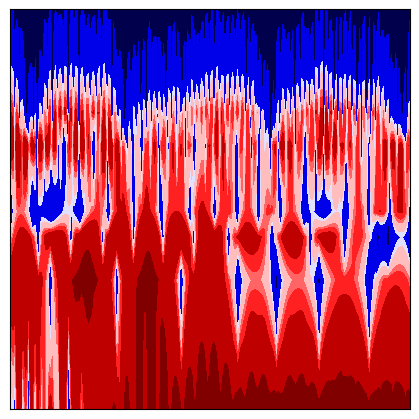

In [ ]:
t = 0.5
time = np.arange(0,256,1)
scales = [0.1,4.3,7.3,21.3,32,64,512]
x = yf
signal = sensorValue

def plot_wavelet(ax, time, signal, scales, waveletname = 'morl', 
                 cmap = plt.cm.seismic, title = '', ylabel = '', xlabel = ''):
    
    dt = 0.5

    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    
    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
    
    levels = [0.1,4.3,7.3,21.3,32,64,512]

    contourlevels = np.log2(levels)
    
    im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)
    
    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)
    
    yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
   
    ax.invert_yaxis()
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], -1)
    return yticks, ylim

fig, ax = plt.subplots(figsize=(4, 4))
plot_wavelet(ax, time, signal, scales, xlabel='', ylabel='', title='')

ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.margins(x=0,y=0)
plt.tight_layout(pad=0, rect=(0,0,0,0))
plt.show()

In [ ]:
def extract_frequency_band_power_information(input_data):

    coords = pd.read_csv('/content/drive/MyDrive/Major project /EEG plotting_10005.txt', sep='\t',  header = None)
    coords = coords.drop(coords.columns[4], axis=1)

    neeg = EEG_data.drop(columns=['matching condition','name','trial number', 'subject identifier','time', 'sample num', 'sensor value'])

    neeg = neeg.drop_duplicates()

    neeg = neeg.reset_index(drop=True)


    trials_dic = {}

    dbc = 0

    if Alc_base.shape == Con_base.shape:
        
        #print('Same shape error:')
        #print(Alc_base.shape)
        #print(Con_base.shape)
        raise SystemExit 

    if input_data.shape == Alc_base.shape[0]:
      dbc = EEG_data

    if input_data.shape == Con_base.shape[0]:
      dbc = EEG_data_control
    
    if input_data[0] == Alc_S1ObjTrials_fft[0]:

      dbc = Alc_S1Obj

    if input_data[0] == Alc_S2MatchTrials_fft[0]:

      dbc = Alc_S2Match

    if input_data[0] == Alc_S2NomatchTrials_fft[0]:

      dbc = Alc_S2Nomatch

    if input_data[0] == Con_S1ObjTrials_fft[0]:

      dbc = Con_S1Obj
      
    if input_data[0] == Con_S2MatchTrials_fft[0]:

      dbc = Con_S2Match

    if input_data[0] == Con_S2NomatchTrials_fft[0]:

      dbc = Con_S2Nomatch

    for pos in input_data:
        #print(pos)
        #print(input_data.shape)
        #print(dbc)        
        
        fullTrialData = dbc[dbc['trial number'] == pos]

        
        
        testSubjectNameList = fullTrialData.name.unique()
       
        for nameID in testSubjectNameList:
            trial_subject  = fullTrialData.loc[fullTrialData['name'] == nameID]
       

            frameName = str(pos) + '_' + nameID              
            trial_subject = trial_subject.pivot_table(index='channel', columns='time', values = 'sensor value')

            trials_dic[frameName] = trial_subject

    print('loop done, length of trials dictionary')
    print(len(trials_dic))

    RGB_dic = {}


    for key in trials_dic:
        
        data = trials_dic.get(key)
        

        fft_raw = fft(data)

        fft_vals = np.absolute(fft_raw)

        fft_vals = normalize(fft_vals, axis=1)

       
        fs = 256    

        fft_freq = fftfreq(fs, 1.0/fs)

        eeg_bands = {'Theta': (4, 7),
                  'Alpha': (8, 12),
                  'Beta': (13, 30),
                  }
        
       
        eeg_band_fft = defaultdict(list)

        for band in eeg_bands:  
        

            freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                                (fft_freq <= eeg_bands[band][1]))[0]


            
            for channel in fft_vals:
        
                filterdch = channel[freq_ix]
                
                sqdvals = np.square(filterdch)
                
                sumvals = np.sum(sqdvals, axis=0)
                
                eeg_band_fft[band].append(sumvals)
                

        extracted_df =  pd.DataFrame(eeg_band_fft)

        extracted_df = extracted_df.reset_index(drop=True)
        neeg = neeg.reset_index(drop=True)

        e_names =  neeg
        e_names = e_names.rename(columns = {'sensor position' : 0})

        extracted_df = extracted_df.join(neeg)

        testerd = pd.merge(e_names, coords, on=0,  how='inner')

        testerd.set_index('channel', inplace=True)

        testerd.columns = ['pos','x', 'y', 'z']

        extracted_df = extracted_df.rename(columns={'sensor position': "pos"})

        extracted_df = pd.merge(extracted_df, testerd, on="pos", how='inner')
        extracted_df = extracted_df.drop(['x','y','z'], axis=1)
        extracted_df.set_index('channel', inplace=True)

        extracted_df = extracted_df.drop(columns=['pos'])
        extracted_df.index.names = ['pos']
  
        class Point(object):
            def __init__(self,x, y, z):
                self.x = x
                self.y = y
                self.z = z

        class AzimuthalEquidistantProjection(object):
            """ 
                http://mathworld.wolfram.com/AzimuthalEquidistantProjection.html
                http://mathworld.wolfram.com/SphericalCoordinates.html
            """
            def __init__(self):

                self.t1 = pi / 2 
                self.l0 = 0 
                self.cost1 = cos(self.t1)
                self.sint1 = sin(self.t1)
        
            def project(self, point):
        
                hxy = np.hypot(point.x, point.y)
        
                t = np.arctan2(point.z, hxy)
                l = np.arctan2(point.y, point.x)
      
        
                costcosll0 = cos(t) * cos(l-self.l0)
                sint = sin(t)
        
                c = acos ((self.sint1) * (sint) + (self.cost1) * costcosll0)
                k = c / sin(c)
        
                x = k * cos(t) * sin(l-self.l0)
                y = k * (self.cost1 * sint - self.sint1 * costcosll0)
                return x, y


        projected_df =  pd.DataFrame()

        for index, row in testerd.iterrows():

            x = row['x']
            y = row['y']
            z = row['z']


            p = AzimuthalEquidistantProjection()
            r = p.project(Point(x,y,z))

            r = pd.Series(r)

            projected_df = projected_df.append(r,ignore_index=True)
        

        projected_df =  projected_df.rename(columns={0: 'X',1: 'Y'})



        new_df = projected_df.join(extracted_df)
        new_df = new_df.drop([31])

        Theta_df = new_df.drop(['Alpha','Beta','X','Y'], axis=1)
        Alpha_df = new_df.drop(['Theta','Beta','X','Y'], axis=1)
        Beta_df = new_df.drop(['Theta','Alpha','X','Y'], axis=1)
        

        xpoints = np.array(new_df[['X']].squeeze())
        ypoints = np.array(new_df[['Y']].squeeze())

        Thetavalues = np.array(Theta_df).squeeze()
        Alphavalues = np.array(Alpha_df).squeeze()
        Betavalues = np.array(Beta_df).squeeze()
        

        xx,yy = np.mgrid[-1.5:1.5:32j, -1.5:1.5:32j]

        Thetavalues = minmax_scale(Thetavalues,feature_range=(0.0, 1.0), axis=0)
        Alphavalues = minmax_scale(Alphavalues,feature_range=(0.0, 1.0), axis=0)
        Betavalues = minmax_scale(Betavalues,feature_range=(0.0, 1.0), axis=0)

        Thetagrid = griddata((xpoints, ypoints), Thetavalues, (xx, yy),method='cubic', fill_value = 0.0)
        Alphagrid = griddata((xpoints, ypoints), Alphavalues, (xx, yy),method='cubic', fill_value = 0.0)
        Betagrid = griddata((xpoints, ypoints), Betavalues, (xx, yy),method='cubic', fill_value = 0.0)

        RGB = np.empty((32, 32, 3))

        RGB[:,:,0] = Thetagrid
        RGB[:,:,1] = Alphagrid
        RGB[:,:,2] = Betagrid

        RGB_dic[key] = RGB

    lendict = len(RGB_dic)

    lenlist=np.arange(0,lendict)

    final_dict = dict(zip(lenlist, list(RGB_dic.values()))) 
    return final_dict

In [ ]:
import numpy as np

def pull_trial_numbers(input_data):
    trialNumbers = input_data['trial number'].unique()
    if len(trialNumbers) == 0:
        return np.array([0])
    else:
        return np.array(trialNumbers)
        
Alc_S1ObjTrials_fft = pull_trial_numbers(Alc_S1Obj)
Alc_S2MatchTrials_fft = pull_trial_numbers(Alc_S2Match)
Alc_S2NomatchTrials_fft = pull_trial_numbers(Alc_S2Nomatch)

Con_S1ObjTrials_fft = pull_trial_numbers(Con_S1Obj)
Con_S2MatchTrials_fft = pull_trial_numbers(Con_S2Match)
Con_S2NomatchTrials_fft = pull_trial_numbers(Con_S2Nomatch)

Alc_base = EEG_data['trial number'].unique()
Con_base = EEG_data_control['trial number'].unique()

print(Alc_S1ObjTrials_fft)
print(Con_S2MatchTrials_fft)

[14 18 16  0  8 22  6 10  2 12 20  4 24 28 26 30 38 50 32 34 36 40 42 48
 46 44]
[ 25  17  71  27  23  51  47  41  55  65   3  11   9  37  77  79  75 107
  97  61  91  99 101  85  81 105 119 113 109 117]


In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Alc_S1Obj_Dict_fft = extract_frequency_band_power_information(Alc_S1ObjTrials_fft)
Alc_S2Match_Dict_fft = extract_frequency_band_power_information(Alc_S2MatchTrials_fft)
Alc_S2Nomatch_Dict_fft = extract_frequency_band_power_information(Alc_S2NomatchTrials_fft)

Con_S1Obj_Dict_fft = extract_frequency_band_power_information(Con_S1ObjTrials_fft)
Con_S2MatchDict_fft = extract_frequency_band_power_information(Con_S2MatchTrials_fft)
Con_S2Nomatch_Dict_fft = extract_frequency_band_power_information(Con_S2NomatchTrials_fft)


Streaming output truncated to the last 5000 lines.

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]]), 56: array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
    

In [ ]:
def merge_dicts(dict1, dict2, dict1_len, dict2_len):
    merged_dict = {}
    merged_dict.update(dict1)
    next_dict_keys = [key + dict1_len for key in dict2.keys()]
    tmp_dict = dict(zip(next_dict_keys, dict2.values()))
    merged_dict.update(tmp_dict)
    return merged_dict

alc_dict_fft = merge_dicts(Alc_S1Obj_Dict_fft, Alc_S2Match_Dict_fft, len(Alc_S1Obj_Dict_fft), len(Alc_S2Match_Dict_fft))
alc_dict_fft = merge_dicts(alc_dict_fft, Alc_S2Nomatch_Dict_fft, len(alc_dict_fft), len(Alc_S2Nomatch_Dict_fft))

con_dict_fft = merge_dicts(Con_S1Obj_Dict_fft, Con_S2MatchDict_fft, len(Con_S1Obj_Dict_fft), len(Con_S2MatchDict_fft))
con_dict_fft = merge_dicts(con_dict_fft, Con_S2Nomatch_Dict_fft, len(con_dict_fft), len(Con_S2Nomatch_Dict_fft))


In [ ]:
def save_array_as_image(inputDict, is_alc):
    import numpy as np
    import cv2
    
    for k, v in inputDict.items():
        imName = f"{k}_{is_alc}.jpg"
        v = np.clip(v * 255, 0, 255).astype(np.uint8)
        cv2.imwrite(imName, v)


In [ ]:
 
%cd /content/drive/MyDrive/Major_project/

%cd /content/drive/MyDrive/Major_project/EEG_Images_fft


# !mkdir /content/drive/MyDrive/Major_project/EEG_Images_fft/Alc
# !mkdir /content/drive/MyDrive/Major_project/EEG_Images_fft/Con


%cd /content/drive/MyDrive/Major_project/EEG_Images_fft/Con
save_array_as_image(con_dict_fft,is_alc=False)

%cd /content/drive/MyDrive/Major_project/EEG_Images_fft/Alc
save_array_as_image(alc_dict_fft,is_alc=True)

/content/drive/MyDrive/Major_project
/content/drive/MyDrive/Major_project/EEG_Images_fft
/content/drive/MyDrive/Major_project/EEG_Images_fft/con1
/content/drive/MyDrive/Major_project/EEG_Images_fft/alc1
